# Modelos difusivos

La idea central de los modelos difusivos, también llamados modelos probabilísticos difusivos de denoising (DDPM), es tomar cada imagen de entrenamiento y corromperla mediante un proceso de ruido en múltiples pasos para transformarla en una distribución gaussiana. Luego, se entrena una red neuronal profunda para invertir este proceso (denoising) y una vez entrenada, la red puede generar nuevas imágenes comenzando con muestras de una distribución gaussiana como entrada.
Los modelos difusivos pueden considerarse una forma de autoencoder variacional jerárquico en el que la distribución del encoder está fija y se define mediante el proceso de ruido, y solo se aprende la distribución generativa o del decoder.
Los modelos difusivos consisten entonces en dos procesos:
* Un proceso de difusión hacia adelante fijo (o predefinido) $q$: Este proceso, de nuestra elección, agrega gradualmente ruido gaussiano a una imagen hasta que se convierte en ruido puro.
* Un proceso de difusión inverso de denoising aprendido $p_\theta$: Aquí, se entrena una red neuronal para deshacer gradualmente el ruido de una imagen, comenzando desde ruido puro, hasta llegar a una imagen real.

<p align="center">
    <img src="https://drive.google.com/uc?id=1foO8OEU-xWcwkeB99EOKKvTEoc87aPVR" width="600" />
</p>

Tanto el proceso hacia adelante como el proceso inverso, indexados por $t$, ocurren durante un número finito de pasos de tiempo $T$. Comienzamos con $t=0$, donde muestreamos una imagen real $\mathbf{x}_0$ de la distribución de datos. En cada paso de tiempo $t$, el proceso hacia adelante muestrea algún ruido de una distribución gaussiana, que se añade a la imagen del paso de tiempo anterior.

Dado un $T$ suficientemente grande y un programa bien definido para añadir ruido en cada paso, terminas con lo que se llama una distribución gaussiana isotrópica a través de un proceso gradual, donde la imagen original se ha transformado completamente en ruido.

La imagen original $\mathbf{x}_0$ es la única variable observada, mientras que las imágenes corrompidas por ruido $\mathbf{x}_1$, $\ldots$, $\mathbf{x}_t$, $\ldots$, $\mathbf{x}_T$ se consideran **variables latentes**.

## Dataset

Continuamos trabajando con el dataset FashionMNIST, para poder analizar comparativamente el desempeño de los diferentes modelos generativos.

In [ ]:
#@title Inicializacion


# Importa los módulos
import math
import numpy as np
from inspect import isfunction
from functools import partial
from einops import rearrange

import torch
import torch.nn as nn
from torch import einsum
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from tqdm import tqdm


# Definicion de variables globales
BATCH_SIZE = 20     # Tamaño de lote
IMG_SIZE = 32       # Tamaño de la imagen
C_IN = 1            # Numero de canales de entrada

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

DEVICE

'cuda'

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.28MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.1MB/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



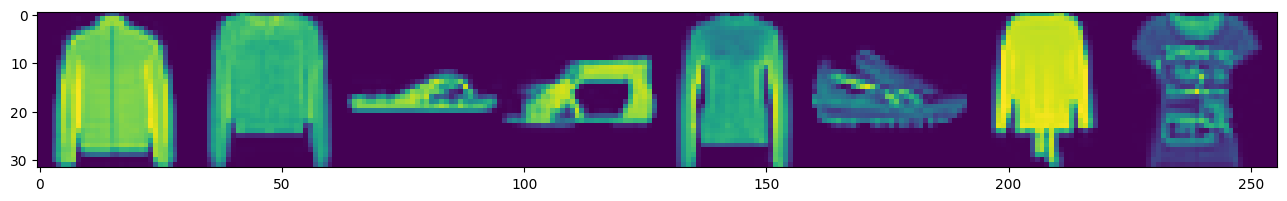

In [ ]:
#@title Carga y preprocesamiento de los datos

# Define una función para cargar y transformar los datos de entrada
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),    # Cambia el tamaño de las imágenes
        transforms.RandomHorizontalFlip(),          # Aplica un volteo horizontal aleatorio a las imágenes, lo que ayuda a aumentar la variedad de datos para mejorar la generalización del modelo.
        transforms.ToTensor(),                      # Convierte las imagenes a tensores de PyTorch, escalando automáticamente los valores de píxeles a un rango [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1)    # Aplica una transformación para escalar los valores de los tensores de [0, 1] a [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms) # Combina las transformaciones definidas en data_transforms en un único objeto que se aplicará a las imágenes de forma secuencial.

    # Descarga el conjunto de datos de entrenamiento (train=True) de FashionMNIST (si no está disponible localmente) en el directorio actual (root="."), aplicando las transformaciones definidas.
    data = torchvision.datasets.FashionMNIST(root=".", download=True, train=True, transform=data_transform)
    return data

# Define una función para mostrar las imágenes
def plot_images(images, title=None):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    if title:
      plt.title(title)
    plt.show()


data = load_transformed_dataset()

# Crea un generador que itera sobre el conjunto de datos para particinarlos en lotes
dataloader = DataLoader(data,
                        batch_size=BATCH_SIZE, # Tamaño de cada lote
                        shuffle=True,          # Mezcla aleatoriamente los datos antes de iterarlos
                        drop_last=True         # Descarta el último lote si no tiene el tamaño completo
                        )
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## Proceso de difusion hacia adelante (Encoder)

Supongamos que muestreamos una imagen $ \mathbf{x}_0$ del conjunto de entrenamiento, y la mezclamos con ruido gaussiano, lo que da como resultado una imagen corrompida por ruido $ \mathbf{x}_1 $ definida por:

$$
\mathbf{x}_1 = \sqrt{1 - \beta_1} \, \mathbf{x}_0 + \sqrt{\beta_1} \, \epsilon_1,
$$

donde $ \epsilon_1 \sim \mathcal{N}(0, I) $ y $ \beta_1 < 1 $ es la varianza de la distribución de ruido.

Podemos escribir la transformación de la siguiente manera:

$$
q(\mathbf{x}_1 | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_1 | \sqrt{1 - \beta_1} \, \mathbf{x}_0, \beta_1 \, I).
$$

Luego repetimos el proceso con pasos adicionales de ruido gaussiano independiente para obtener una secuencia de imágenes cada vez más ruidosas $ \mathbf{x}_2, \ldots, \mathbf{x}_T $.

Cada imagen sucesiva está dada por:

$$
\mathbf{x}_t = \sqrt{1 - \beta_t} \, \mathbf{x}_{t-1} + \sqrt{\beta_t} \, \epsilon_t,
$$

donde $ \epsilon_t \sim \mathcal{N}(0, I) $. Nuevamente, podemos escribirla como una distribucion gaussiana condicional:

$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t | \sqrt{1 - \beta_t} \, \mathbf{x}_{t-1}, \beta_t \, I).
$$

La secuencia de distribuciones condicionales forman una cadena de Markov. Esto significa que la distribución de $ \mathbf{x}_t $ depende únicamente de $ \mathbf{x}_{t-1} $ y no de las imágenes anteriores, lo que caracteriza el proceso de difusión como un modelo de Markov.

Note que los $ \beta_t $ no son constantes en cada paso de tiempo $ t $ sino que se definen mediante un "programa de varianza", que puede ser lineal, cuadrático, coseno, etc.

Una consecuencia directa del proceso hacia adelante construido $ q $ es que podemos muestrear $ \mathbf{x}_t $ en cualquier nivel de ruido arbitrario condicionado a $\mathbf{x}_0 $ (ya que la suma de gaussianas también es gaussiana). Esto es muy conveniente: no necesitamos aplicar $ q $ repetidamente para muestrear $ \mathbf{x}_t $. Tenemos que

$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \, \mathbf{x}_0, (1 - \bar{\alpha}_t) \, I)$$  

con $ \alpha_t := 1 - \beta_t $ y $ \bar{\alpha}_t := \prod_{s=1}^{t} \alpha_s $.

Esta ecuación se conoce como "diffusion kernel".
Esto significa que podemos muestrear ruido gaussiano, escalarlo apropiadamente y añadirlo a $ \mathbf{x}_0 $ para obtener $ \mathbf{x}_t $ directamente. Nota que los $ \bar{\alpha}_t $ son funciones del programa de varianza $ \beta_t $ y, por lo tanto, también son conocidos y pueden ser precomputados.

Veamos en codigo como definir el proceso hacia adelante.
Utilizaremos un **programa de varianza linear** para $T=200$ pasos de tiempo, donde $\beta_1$ aumentará lienalemente desde $ \beta_1 = 10^{-4} $ hasta $ \beta_T = 0.02 $. También definimos las diversas variables que derivan de $ \beta_t $ como el producto acumulado de las varianzas $ \bar{\alpha}_t $.

In [ ]:
#@title Definimos el proceso difusivo hacia adelante

# Define a linear variance shedule
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# define forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


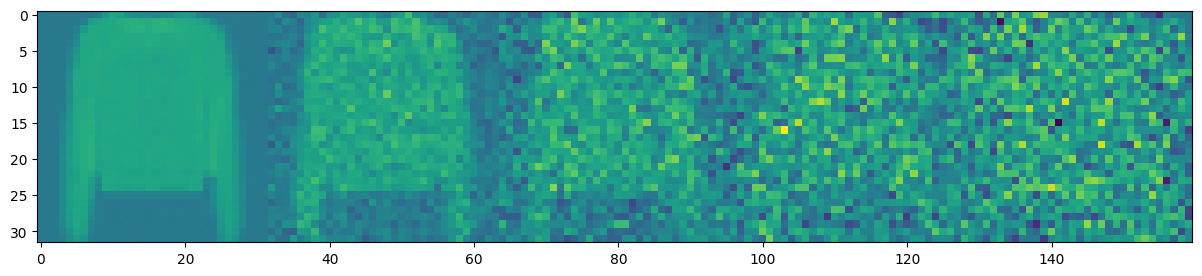

In [ ]:
#@title Graficamos el proceso de agegado de ruido para pasos sucesivos de tiempo

x_start = batch_x[1:2]
plot_images(torch.cat([q_sample(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]], dim=0))

## Proceso de difusion hacia atras (Decoder)

En el proceso de difusion adelante adelante, comenzamos desde $ x_0 $, terminamos con $ x_1, \ldots, x_t, \ldots, x_T $, donde $ x_T $ es ruido gaussiano puro si configuramos el programa de manera apropiada.

En el proceso difusivo hacia atras, nuestro objetivo es aprender a deshacer el proceso de ruido, por lo que es natural considerar la reversa de la distribución condicional $ q(x_t | x_{t-1}) $, que podemos expresar utilizando el teorema de Bayes en la forma:

$$
q(x_{t-1} | x_t) = \frac{q(x_t | x_{t-1}) q(x_{t-1})}{q(x_t)}.
$$

Podemos escribir la distribución marginal $ q(x_{t-1}) $ en la forma

$$
q(x_{t-1}) = \int q(x_{t-1} | x) p(x) \, dx,
$$

Sin embargo, esta distribución es intractable, porque debemos integrar sobre la densidad de datos desconocida $ p(x) $ correspondiente a todas las posibles imagenes.
Por lo tanto, vamos a utilizar una red neuronal para aproximar (aprender) esta distribución de probabilidad condicional, llamémosla $ p_\theta(x_{t-1} | x_t) $, donde $ \theta $ son los parámetros de la red neuronal, actualizados mediante descenso de gradiente.

Entonces, necesitamos una red neuronal para representar una distribución de probabilidad (condicional) del proceso hacia atrás. Si asumimos que este proceso inverso también es gaussiano, recordemos que cualquier distribución gaussiana se define por 2 parámetros:

*  una media parametrizada por $ \mu_\theta $;
* una varianza parametrizada por $ \Sigma_\theta $;

por lo que podemos parametrizar el proceso como

$$
p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

donde la media y la varianza también están condicionadas al nivel de ruido $ t $.En la implementación original, la varianza se mantiene fija, y se permite que la red neuronal solo aprenda (represente) la media $ \mu_\theta $ de esta distribución de probabilidad condicional.

### Arquitectura de la red neuronal
La red neuronal debe recibir una imagen ruidosa correspondiente un tiempo $t$ particular y devolver la imagen sin ruido. De hecho, como veremos más adelante, la red no predice la imagen sin ruido, sino que lo que predice es el ruido contenido en la imagen de entrada. Notese que  el ruido predicho es un tensor que tiene el mismo tamaño/resolución que la imagen de entrada. Por lo tanto, técnicamente, la red toma y devuelve tensores de la misma forma. Lo que se usa aqui es una arquitectura muy parecida a la Autoencoder, especificamente una **U-Net**. Esta red, al igual que un autoencoder, consiste en un cuello de botella en el medio que asegura que la red aprenda solo la información más importante. Sin embargo, la U-Net intriduce conexiones residuales entre el codificador y el decodificador, lo que mejora considerablemente el flujo de gradientes.  

<p align="center">
    <img src="https://drive.google.com/uc?id=1_Hej_VTgdUWGsxxIuyZACCGjpbCGIUi6" width="600" />
</p>

Como se puede ver, un modelo U-Net primero reduce la resolución espacial de la entrada (es decir, hace que la entrada sea más pequeña en términos de resolución espacial), tras lo cual se realiza un proceso de aumento de resolución.

En DDPM la U-Net regular es aumentada con modulos de ResNets, módulos de atención e incoporpora embddings posicionales para tener en cuenta la dependencia temporal.

#### **Embeddings posicionales sinusoidales**
Dado que los parámetros de la red neuronal se comparten a lo largo del tiempo (nivel de ruido) se utilizan embeddings de posición sinusoidales para codificar $t$, inspiradas en los Transformers
Esto permite que la red neuronal "sepa" en qué paso de tiempo particular (nivel de ruido) está operando, para cada imagen en un batch.



In [ ]:
#@title Definimos la U-Net

# Definimos algunas funciones auxiliares

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# Definimos módulo Residual, que simplemente suma la entrada a la salida de una función particular (en otras palabras, añade una conexión residual a una función específica).
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# definimos alias para las operaciones de aumento y reducción de resolución
def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


# Definicion Empeddings posicionales sinusoidales
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Definicion de los Modulos de ResNet
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

# Definicion de los bloques de atencion
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

# Definicion de clase para normalización por grupos
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# Definicion de la U-Net propiamente dicha
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)






## Función de perdida

El proceso de denoising completo, se puede expresar como una cadena de Markov:

$$
p_{\theta}(x, x_1, x_2, \ldots, x_T) = p(x_T) \{ \prod_{t=2}^{T} p(x_{t-1} | x_t, w) \} p_{\theta}(x | x_1)
$$

La función de verosimilitud:

$$
p_{\theta}(x) = \int \cdots \int p_{\theta}(x, x_1, \ldots, x_T) \, dx_1 \ldots dx_T
$$

es intratable debido a que implican integrar sobre funciones de redes neuronales altamente complejas. Podemos adoptar un enfoque similar al utilizado con los VAEs y maximizar un límite inferior en la verosimilitud logarítmica o Evidence Lower Bound (ELBO):

$$
\log p_{\theta}(x) \geq \mathcal{L}(\theta)
$$

Resulta que el ELBO para este proceso es una suma de pérdidas en cada paso de tiempo $t$:

$$
\mathcal{L} = \mathcal{L_0} + \mathcal{L_1} + \ldots + \mathcal{L_T}
$$

Por la construcción del proceso hacia adelante $ q $ y del proceso hacia atrás, cada término (excepto $ L_0 $) de la pérdida es en realidad la divergencia KL entre dos distribuciones gaussianas, la cual puede expresarse explícitamente como una diferencia de cuadrados (MSE) respecto a sus medias.

### Reparametrización de las medias

Una modificación que conduce a resultados de mayor calidad es cambiar el papel de la red neuronal. En lugar de predecir la imagen sin ruido en cada paso de la cadena de Markov, la red neuronal predice el componente total de ruido que se agregó a la imagen original para crear la imagen ruidosa.
Para ello, reparametrizamos las medias en los terminos de KL que constituyen las perdidas para que la red neuronal aprenda (prediga) el ruido agregado $ \epsilon_\theta(x_t, t) $, para el nivel de ruido $ t $:

La función objetivo final $ \mathcal{L_t} $ se expresa de la siguiente manera (para un paso de tiempo aleatorio $ t $, dado $ \epsilon \sim \mathcal{N}(0, I) $):

$$
\|\epsilon - \epsilon_\theta(x_t, t)\|^2 = \|\epsilon - \epsilon_\theta\left(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, t\right)\|^2.
$$



In [ ]:
#@title Definimos la función de perdida

def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Pasos para el entrenamiento del decoder

El procedimiento general de entrenamiento es el siguiente:

<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

* Tomamos una muestra aleatoria $ \mathbf{x}_0 $ de la distribución de datos real desconocida $ q(\mathbf{x}_0) $.
* Muestreamos un nivel de ruido $ t $ de manera uniforme entre $ 1 $ y $ T $ (es decir, un paso de tiempo aleatorio).
* Muestreamos un ruido de una distribución gaussiana y corrompemos la entrada con este ruido en el nivel $ t $, utilizando las propiedades definidas anteriormente.
* La red neuronal se entrena para predecir este ruido basado en la imagen corrupta $ \mathbf{x}_t $, es decir, el ruido aplicado a $ \mathbf{x}_0 $

## Pasos para el Muestreo

Como muestreamos del modelo durante el entrenamiento (para poder seguir el progreso), definimos el código para eso a continuación:

<p align="center">
<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7" width="400" />
</p>

La generación de nuevas imágenes a partir de un modelo de difusión ocurre al invertir el proceso de difusión: comenzamos desde $ T $, donde muestreamos ruido puro de una distribución gaussiana, y luego utilizamos nuestra red neuronal para deshacer gradualmente el ruido (usando la probabilidad condicional que ha aprendido), hasta llegar al paso de tiempo $ t = 0 $.

El código a continuación implementa el muestreo.

In [ ]:
#@title Muestreo

@torch.no_grad()  # desactivar el cálculo del gradiente durante la ejecución de la siguiente función.
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

def plot(samples, n, timesteps, batch_size):
  # Dividir timesteps en n muestras igualmente separadas
  n_indices = [i * (timesteps // n) for i in range(n)]

  # show a random one
  random_index = torch.randint(0, batch_size,(1,))

  to_plot = torch.cat([torch.tensor(samples[t][random_index]) for t in n_indices], dim=0).reshape(n, C_IN, IMG_SIZE, IMG_SIZE)
  return to_plot

In [ ]:
#@title Definimos el Modelo

from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=IMG_SIZE,
    channels=C_IN,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

100%|██████████| 3000/3000 [02:27<00:00, 20.38it/s]


[Epoch: 1/5] [loss: 0.0521]


100%|██████████| 3000/3000 [02:24<00:00, 20.83it/s]


[Epoch: 2/5] [loss: 0.0330]


sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 78.68it/s]


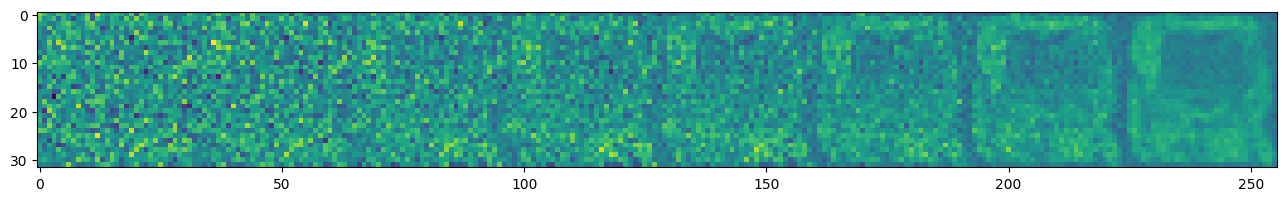

100%|██████████| 3000/3000 [02:25<00:00, 20.63it/s]


[Epoch: 3/5] [loss: 0.0307]


100%|██████████| 3000/3000 [02:22<00:00, 21.00it/s]


[Epoch: 4/5] [loss: 0.0294]


sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 79.97it/s]


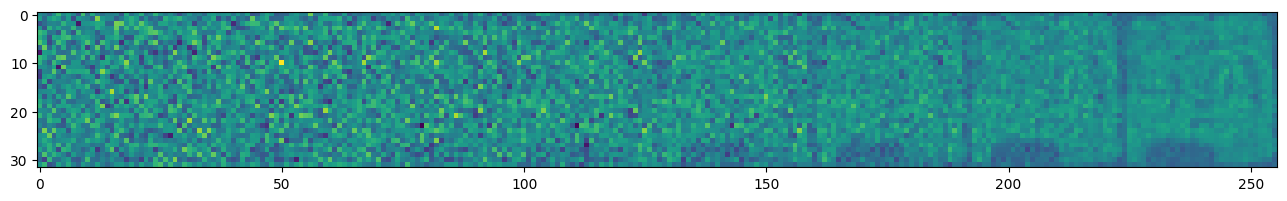

100%|██████████| 3000/3000 [02:23<00:00, 20.98it/s]

[Epoch: 5/5] [loss: 0.0288]


In [ ]:
#@title Entrenamos la red

from torchvision.utils import save_image

epochs = 5

history = dict(loss=[])
for epoch in range(epochs):
    total_loss = []
    for step, (batch_x,_) in enumerate(tqdm(dataloader)):
      optimizer.zero_grad()

      batch_size = batch_x.shape[0]
      batch = batch_x.to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      loss.backward()
      optimizer.step()
      total_loss.append(loss.item())
    mean_loss = np.mean(total_loss)
    print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, epochs, mean_loss)
            )
    if epoch % 2:
      samples = sample(model, image_size=IMG_SIZE, batch_size=20, channels=C_IN)
      plot_images(plot(samples, 8, timesteps, batch_size))


# Actividad:

* El modelo difusivo entrenado tiene el problema que genera muestras de cualquier tipo de prenda. Si yo quiero muestrar, por ejemplo solo zapatos, ¿como podria entrenar un DDPM condicionado por el tipo de prenda?